<a href="https://colab.research.google.com/github/Satyam-kumar-yadav/EfficientNetB5_breed_pred/blob/main/Densenet121_breed_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import glob
import numpy as np
import pandas as pd
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.filters import sobel
from keras.optimizers import SGD,Adam
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense,Flatten,Dropout,AvgPool2D
from keras.layers.normalization import BatchNormalization
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

In [3]:
labels = pd.read_csv('/content/drive/My Drive/Snake_breed/dataset/train.csv')
labels

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix
...,...,...
5503,5f0c970adf,lampropeltis-triangulum
5504,f6a4287fac,pantherophis-alleghaniensis
5505,d3c10e63e1,thamnophis-sirtalis
5506,61ef50879c,pituophis-catenifer


In [4]:
breeds=list(labels['breed'].unique())
len(breeds)

35

In [5]:
!nvidia-smi

Fri Nov 13 14:43:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
path = '/content/drive/My Drive/Snake_breed/dataset/train/a8b3ad1dde.jpg'

0    nerodia-erythrogaster
Name: breed, dtype: object

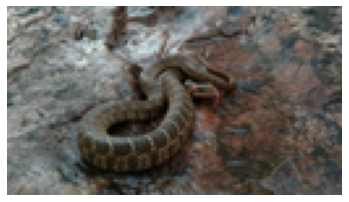

In [ ]:
img = load_img(path)
plt.grid(False)
plt.axis('OFF')
plt.imshow(img)
lab_ = path.split('/')[-1]
labels['breed'].loc[labels['image_id'] == lab_.split('.')[0]]


In [9]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
# from keras.applications.resnet50 import preprocess_input

image_size=128
image_path='/content/drive/My Drive/Snake_breed/dataset/new_train/'

train_datagen=ImageDataGenerator(
                        rescale=1./255,
                        validation_split=0.1,
                        horizontal_flip=True,
                        zoom_range=0.2,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        rotation_range=40,
                        fill_mode='nearest',
                        vertical_flip = True
                        )

train_generator=train_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='training',
                        shuffle=True,
                         batch_size=32,
                        class_mode='categorical'
                        )

valid_datagen=ImageDataGenerator(
                        validation_split=0.1,
                        rescale=1./255
                        )

valid_generator=valid_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='validation',
                        shuffle=False,
                         batch_size=32,
                        class_mode='categorical'
                        )

Found 4973 images belonging to 35 classes.
Found 535 images belonging to 35 classes.


In [10]:
x,y = train_generator.next()
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'agkistrodon-contortrix', 1: 'agkistrodon-piscivorus', 2: 'coluber-constrictor', 3: 'crotalus-atrox', 4: 'crotalus-horridus', 5: 'crotalus-ruber', 6: 'crotalus-scutulatus', 7: 'crotalus-viridis', 8: 'diadophis-punctatus', 9: 'haldea-striatula', 10: 'heterodon-platirhinos', 11: 'lampropeltis-californiae', 12: 'lampropeltis-triangulum', 13: 'masticophis-flagellum', 14: 'natrix-natrix', 15: 'nerodia-erythrogaster', 16: 'nerodia-fasciata', 17: 'nerodia-rhombifer', 18: 'nerodia-sipedon', 19: 'opheodrys-aestivus', 20: 'pantherophis-alleghaniensis', 21: 'pantherophis-emoryi', 22: 'pantherophis-guttatus', 23: 'pantherophis-obsoletus', 24: 'pantherophis-spiloides', 25: 'pantherophis-vulpinus', 26: 'pituophis-catenifer', 27: 'rhinocheilus-lecontei', 28: 'storeria-dekayi', 29: 'storeria-occipitomaculata', 30: 'thamnophis-elegans', 31: 'thamnophis-marcianus', 32: 'thamnophis-proximus', 33: 'thamnophis-radix', 34: 'thamnophis-sirtalis'}


In [11]:
x.shape , y.shape

((32, 128, 128, 3), (32, 35))

In [ ]:
x_valid , y_valid = valid_generator.next()

In [ ]:
x_valid.shape , y_valid.shape

((32, 128, 128, 3), (32, 35))

In [15]:
from keras.applications.densenet import DenseNet121, preprocess_input

In [18]:
#Defining the model
# base_model = EfficientNetB5(include_top=False, weights="imagenet", input_shape=(128,128,3),classes=y.shape[1])


#Adding the final layers to the above base models where the actual classification is done in the dense layers
base_model = DenseNet121(input_shape = (128 , 128 ,3) ,
                       weights="imagenet",
                       include_top=False)
model= Sequential()
model.add(base_model) 
# model.add(Dense(input_shape = (image_size , image_size , 3) , activation='relu')
model.add(GlobalAveragePooling2D())

# model.add(Flatten()) 

model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512 , activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(breeds),activation='softmax'))

# model.layers[0].trainable=False
for layer in model.layers[:-6]:
    layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 35)               

In [ ]:
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor='loss',   factor=.01,   patience=5,  min_lr=1e-5)

In [ ]:
# callback=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,min_delta=0,mode='auto',restore_best_weights=False,baseline=None)

# learn_rate=.001
# sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
model.compile(optimizer='adam' ,
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )
history=model.fit_generator(train_generator,
                   steps_per_epoch=None,
                   epochs=20,
                   validation_data=valid_generator,
                   validation_steps=4 ,
                  
                  )

In [ ]:
def plot_model(history):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Model Accuracy and Loss')

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train','Valid'],loc=4)

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train','Valid'],loc=1)

    fig.show()

plot_model(history)

In [21]:
for layer in model.layers[:]:
    layer.trainable = True

In [24]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

In [25]:
checkpoint = ModelCheckpoint(
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,min_delta=0,mode='min',restore_best_weights=False,baseline=None)
# for early stop
# early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [ ]:
history = model.fit(train_generator,
                   steps_per_epoch=None,
                   epochs=100,
                   validation_data=valid_generator,
                   validation_steps=4 ,
                              callbacks=[checkpoint, reduce_lr, callback])

In [ ]:
def plot_model(history):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Model Accuracy and Loss')

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train','Valid'],loc=4)

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train','Valid'],loc=1)

    fig.show()

plot_model(history)

In [31]:
model.save('/content/drive/My Drive/Snake_breed/model1/Dense122.h5')

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/Snake_breed/model1/Dense122.h5')

In [34]:
test_generator = valid_datagen.flow_from_directory(
    '/content/drive/My Drive/Snake_breed/dataset/new_test/',
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 2361 images belonging to 1 classes.


In [ ]:
test_generator.reset()
pred=model.predict(test_generator,verbose=1,steps=None)

In [41]:
n = len(labels)
n_class = len(breeds)  
class_to_num = dict(zip(breeds, range(n_class)))
num_to_class = dict(zip(range(n_class), breeds))

df2 = pd.read_csv('/content/drive/My Drive/Snake_breed/dataset/test.csv')

for b in breeds:
    df2[b] = pred[:,class_to_num[b]]
    

df2.to_csv('pred.csv', index=None)

In [42]:
df_4 = pd.read_csv('/content/pred.csv')
df_4.head()

,image_id,nerodia-erythrogaster,pantherophis-vulpinus,thamnophis-sirtalis,pantherophis-obsoletus,agkistrodon-contortrix,crotalus-atrox,lampropeltis-triangulum,crotalus-horridus,crotalus-ruber,heterodon-platirhinos,nerodia-sipedon,thamnophis-elegans,thamnophis-marcianus,crotalus-viridis,nerodia-fasciata,haldea-striatula,storeria-dekayi,agkistrodon-piscivorus,nerodia-rhombifer,storeria-occipitomaculata,thamnophis-radix,coluber-constrictor,natrix-natrix,diadophis-punctatus,masticophis-flagellum,pantherophis-spiloides,rhinocheilus-lecontei,lampropeltis-californiae,pituophis-catenifer,opheodrys-aestivus,pantherophis-guttatus,pantherophis-alleghaniensis,thamnophis-proximus,pantherophis-emoryi,crotalus-scutulatus
0,7ede553357,0.033439,0.010394,0.013039,0.179938,0.033962,0.029269,0.085074,0.047842,0.009284,0.003183,0.035468,0.053197,0.027202,0.009280,0.004284,0.015776,0.006501,0.009381,0.007572,0.004892,0.010807,0.051990,0.008998,0.052238,0.009512,0.014423,0.075058,0.043591,0.027270,0.001077,0.006269,0.039733,0.003437,0.005372,0.031248
1,3500b219e4,0.015778,0.009613,0.019714,0.042899,0.027645,0.004317,0.022692,0.012353,0.016037,0.007655,0.016884,0.078111,0.055569,0.015211,0.009903,0.020890,0.008416,0.015453,0.015701,0.010650,0.024861,0.039102,0.020177,0.069676,0.021330,0.037870,0.065983,0.038490,0.036695,0.004957,0.017684,0.066086,0.020743,0.028260,0.082595
2,d43a78d6d9,0.017572,0.032142,0.026418,0.027032,0.029124,0.006524,0.008009,0.009889,0.015100,0.010021,0.019556,0.026516,0.032186,0.017947,0.026903,0.038857,0.020137,0.037926,0.053108,0.035085,0.042191,0.013335,0.015156,0.064911,0.035772,0.026463,0.047232,0.011204,0.032405,0.008342,0.023061,0.027743,0.046840,0.033357,0.081934
3,1f36f26994,0.002816,0.001827,0.034716,0.002643,0.001037,0.000309,0.000886,0.000668,0.096799,0.128326,0.009803,0.009810,0.010928,0.027318,0.011561,0.025713,0.009731,0.004234,0.014987,0.019394,0.016949,0.004679,0.006516,0.021510,0.004646,0.004524,0.010063,0.001173,0.207507,0.078161,0.029144,0.008984,0.044147,0.046907,0.101583
4,8cb85fc58e,0.026024,0.028244,0.032445,0.026292,0.025594,0.011162,0.009935,0.015301,0.030459,0.024738,0.028385,0.024865,0.036559,0.026855,0.024989,0.033684,0.022580,0.027575,0.043549,0.021644,0.036814,0.019109,0.020752,0.049081,0.025274,0.027161,0.044007,0.012770,0.047668,0.018963,0.029397,0.020819,0.028176,0.027622,0.071509


In [43]:
submission = pd.DataFrame(df_4['image_id'])
data_max = df_4.drop('image_id' , axis = 1)
submission['breed'] = data_max.idxmax(axis = 1)

In [44]:
submission.to_csv('prediction.csv' , index=None)